In [1]:
import boilerplate

import pyrtl
from pyrtl import *

import z3

## Verifying a Boolean circuit

In [2]:
reset_working_block()

_r = [Input(bitwidth=2, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=3, name="out")

r = [[_r[0][0], _r[0][1]], [_r[1][0], _r[1][1]]]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

out <<= concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0])

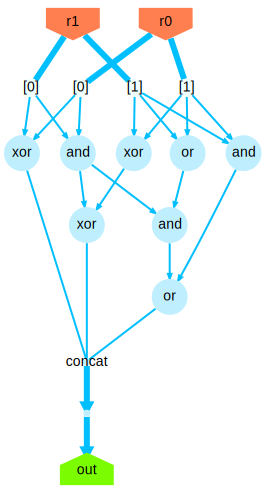

In [3]:
working_block()

In [4]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])


s (1,) [('r0', 2)] [('tmp1', 1)]
s (0,) [('r0', 2)] [('tmp0', 1)]
s (0,) [('r1', 2)] [('tmp2', 1)]
s (1,) [('r1', 2)] [('tmp3', 1)]
|  [('tmp1', 1), ('tmp3', 1)] [('tmp5', 1)]
^  [('tmp1', 1), ('tmp3', 1)] [('tmp9', 1)]
&  [('tmp1', 1), ('tmp3', 1)] [('tmp7', 1)]
^  [('tmp0', 1), ('tmp2', 1)] [('tmp11', 1)]
&  [('tmp0', 1), ('tmp2', 1)] [('tmp4', 1)]
^  [('tmp9', 1), ('tmp4', 1)] [('tmp10', 1)]
&  [('tmp4', 1), ('tmp5', 1)] [('tmp6', 1)]
|  [('tmp6', 1), ('tmp7', 1)] [('tmp8', 1)]
c  [('tmp8', 1), ('tmp10', 1), ('tmp11', 1)] [('tmp12', 3)]
w  [('tmp12', 3)] [('out', 3)]


#### Verifying
_Following is a manual translation of the circuit into a Boolean formula._

In [9]:
_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [10]:
res = s.check([z3.Not(BV2Int(_r[0]) + BV2Int(_r[1]) == BV2Int(out))])
res

unsat

_Implement a function_ `net_to_smt` _that will do the same (or equivalent) translation automatically._

In [6]:
wires, ops, assertions = net_to_smt(wb)

s = z3.Solver()
for phi in assertions:
    print(phi)
    s.add(phi)

tmp1 == Extract(1, 1, r0)
tmp0 == Extract(0, 0, r0)
tmp2 == Extract(0, 0, r1)
tmp3 == Extract(1, 1, r1)
tmp5 == tmp1 | tmp3
tmp9 == tmp1 ^ tmp3
tmp7 == tmp1 & tmp3
tmp11 == tmp0 ^ tmp2
tmp4 == tmp0 & tmp2
tmp10 == tmp9 ^ tmp4
tmp6 == tmp4 & tmp5
tmp8 == tmp6 | tmp7
tmp12 == Concat(Concat(tmp8, tmp10), tmp11)
out == tmp12


In [7]:
res = s.check([z3.Not(BV2Int(wires.lookup('r0')) + BV2Int(wires.lookup('r1')) ==
               BV2Int(wires.lookup('out')))])
res

unsat

In [8]:
s.model() if res == z3.sat else None

## Verify something with memory?

In [11]:
reset_working_block()

sp = Register(bitwidth=3, name='sp')
mem = MemBlock(bitwidth=3, addrwidth=3, name='stack', max_write_ports=2)

mem[sp] <<= (mem[sp] + 1)[:3]
mem[0] <<= 0
sp.next <<= sp + 1

In [12]:
sim_trace = pyrtl.SimulationTrace()
sim = pyrtl.Simulation(tracer=sim_trace)
for cycle in range(14):
    sim.step({})

sim_trace.render_trace()

<IPython.core.display.Javascript object>

In [13]:
sim.inspect_mem(mem)

{0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 1}

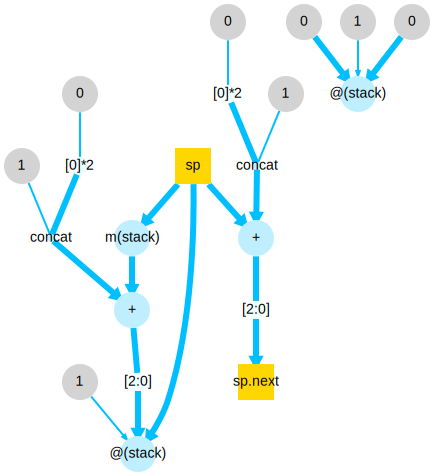

In [15]:
wb

In [14]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

s (0, 0) [('const_1_0', 1)] [('tmp14', 2)]
s (0, 0) [('const_8_0', 1)] [('tmp18', 2)]
m (0, <pyrtl.memory.MemBlock object at 0x1077dcb80>) [('sp', 3)] [('tmp13', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x1077dcb80>) [('const_4_0', 3), ('const_6_0', 3), ('const_5_1', 1)] []
c  [('tmp14', 2), ('const_0_1', 1)] [('tmp15', 3)]
c  [('tmp18', 2), ('const_7_1', 1)] [('tmp19', 3)]
+  [('tmp13', 3), ('tmp15', 3)] [('tmp16', 4)]
s (0, 1, 2) [('tmp16', 4)] [('tmp17', 3)]
+  [('sp', 3), ('tmp19', 3)] [('tmp20', 4)]
s (0, 1, 2) [('tmp20', 4)] [('tmp21', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x1077dcb80>) [('sp', 3), ('tmp17', 3), ('const_2_1', 1)] []
r  [('tmp21', 3)] [('sp', 3)]


In [16]:
list(wb)

[LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x1077dca00>,), dests=(<pyrtl.wire.WireVector object at 0x1077ddfc0>,)),
 LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x1077dea10>,), dests=(<pyrtl.wire.WireVector object at 0x1077df5e0>,)),
 LogicNet(op='m', op_param=(0, <pyrtl.memory.MemBlock object at 0x1077dcb80>), args=(<pyrtl.wire.Register object at 0x1077dca90>,), dests=(<pyrtl.wire.WireVector object at 0x1077dc5b0>,)),
 LogicNet(op='@', op_param=(0, <pyrtl.memory.MemBlock object at 0x1077dcb80>), args=(<pyrtl.wire.Const object at 0x1077df940>, <pyrtl.wire.Const object at 0x1077dc850>, <pyrtl.wire.Const object at 0x1077dc3a0>), dests=()),
 LogicNet(op='c', op_param=None, args=(<pyrtl.wire.WireVector object at 0x1077ddfc0>, <pyrtl.wire.Const object at 0x1077dc640>), dests=(<pyrtl.wire.WireVector object at 0x1077de140>,)),
 LogicNet(op='c', op_param=None, args=(<pyrtl.wire.WireVector object at 0x1077df5e0>, <pyrtl.wire.Const object at 0x10

_You will most likely need to extend your previous implementation of_ `net_to_smt` _to handle state update._

In [17]:
wires, ops, assertions = net_to_smt(wb, mems=[mem])

tr = []
for phi in assertions:
    print(phi)
    tr.append(phi)

tmp14 == Concat(Extract(0, 0, 0), Extract(0, 0, 0))
tmp18 == Concat(Extract(0, 0, 0), Extract(0, 0, 0))
tmp13 == stack[sp]
stack:wport:0 == out(0, 0)
tmp15 == Concat(tmp14, 1)
tmp19 == Concat(tmp18, 1)
tmp16 == Concat(0, tmp13) + Concat(0, tmp15)
tmp17 == Extract(2, 0, tmp16)
tmp20 == Concat(0, sp) + Concat(0, tmp19)
tmp21 == Extract(2, 0, tmp20)
stack:wport:sp == out(sp, tmp17)
sp:next == tmp21
stack:next ==
Store(Store(stack, addr(stack:wport:0), data(stack:wport:0)),
      addr(stack:wport:sp),
      data(stack:wport:sp))


In [18]:
state_vars = [wires.lookup(v) for v in ['sp', 'stack']]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

In [19]:
rules = create_rules()

In [23]:
from verification_utils import CHCs
chcs = CHCs(rules)

In [24]:
s = chcs.create_solver()

In [25]:
s.check()

sat

In [26]:
s.model()

[Inv = [else ->
        And(Or(Not(Extract(2, 2, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Extract(0, 0, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Var(0) == 2), Var(1)[1] == 1 + Var(1)[2]),
            Or(Extract(1, 1, Var(0)) == 1,
               Var(1)[2] == Var(1)[1]))]]